In [69]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [29]:

# Load dataset
df = pd.read_csv("/Users/donald/Desktop/Predictive project/wmt_data.csv")

# Convert 'date' to datetime and filter for 2025 only
df['date'] = pd.to_datetime(df['date'], utc=True)
df['date'] = df['date'].dt.tz_localize(None)
df = df[df['date'] >= '2025-01-01']
df.set_index('date', inplace=True)

In [30]:
df.head()

,open,high,low,close,adj_close,volume
date,,,,,,
2025-01-02 05:00:00,89.980003,90.599998,89.519997,90.000000,89.753525,14820400
2025-01-03 05:00:00,90.150002,91.300003,90.139999,90.779999,90.531387,10834600
2025-01-06 05:00:00,90.830002,92.470001,90.669998,91.430000,91.179611,14519900
2025-01-07 05:00:00,91.699997,91.940002,90.449997,90.809998,90.561302,11238000
2025-01-08 05:00:00,91.110001,91.849998,90.820000,91.800003,91.548599,13453600


**checking if the data is clean**

In [31]:
# Quick summary to check data cleanliness
print('DataFrame Info:')
df.info()

print('\nMissing Values in each column:')
print(df.isnull().sum())

# It is always good practice to check for duplicates as well.
print('\nNumber of duplicate rows:', df.duplicated().sum())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56 entries, 2025-01-02 05:00:00 to 2025-03-25 04:00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       56 non-null     float64
 1   high       56 non-null     float64
 2   low        56 non-null     float64
 3   close      56 non-null     float64
 4   adj_close  56 non-null     float64
 5   volume     56 non-null     int64  
dtypes: float64(5), int64(1)
memory usage: 3.1 KB

Missing Values in each column:
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

Number of duplicate rows: 0


**understanding the behavior of the stock price over time**

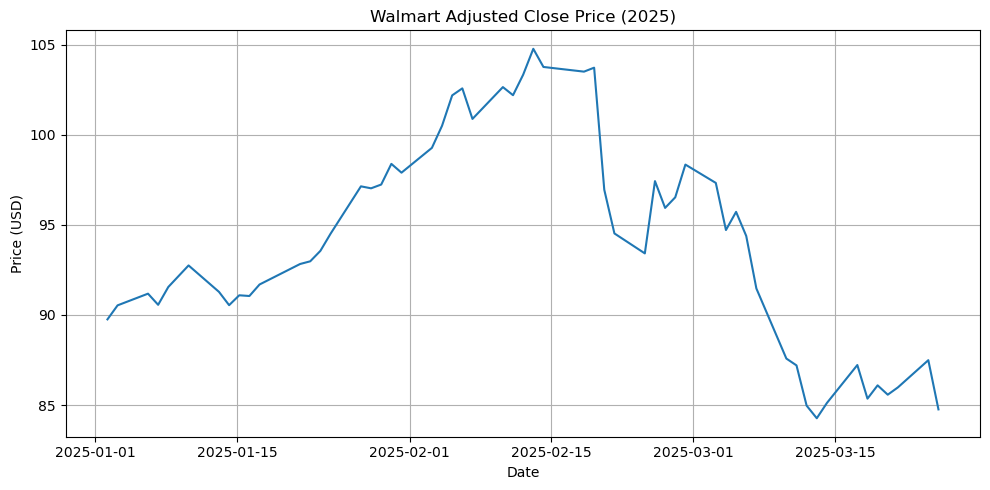

In [33]:

# Plot the Adjusted Close Price
plt.figure(figsize=(10, 5))
plt.plot(df['adj_close'], label='Observed')
plt.title("Walmart Adjusted Close Price (2025)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()


**1. ARIMA**

In [48]:

#  Fit ARIMA(5,1,0) model
arima_model = ARIMA(df['adj_close'], order=(10, 1, 0))
arima_fit = arima_model.fit()

# Print model summary
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              adj_close   No. Observations:                   56
Model:                ARIMA(10, 1, 0)   Log Likelihood                -103.986
Date:                Mon, 14 Apr 2025   AIC                            229.972
Time:                        18:44:49   BIC                            252.053
Sample:                             0   HQIC                           238.511
                                 - 56                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1840      0.159      1.158      0.247      -0.127       0.495
ar.L2          0.0407      0.291      0.140      0.889      -0.529       0.610
ar.L3          0.0631      0.135      0.467      0.6

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


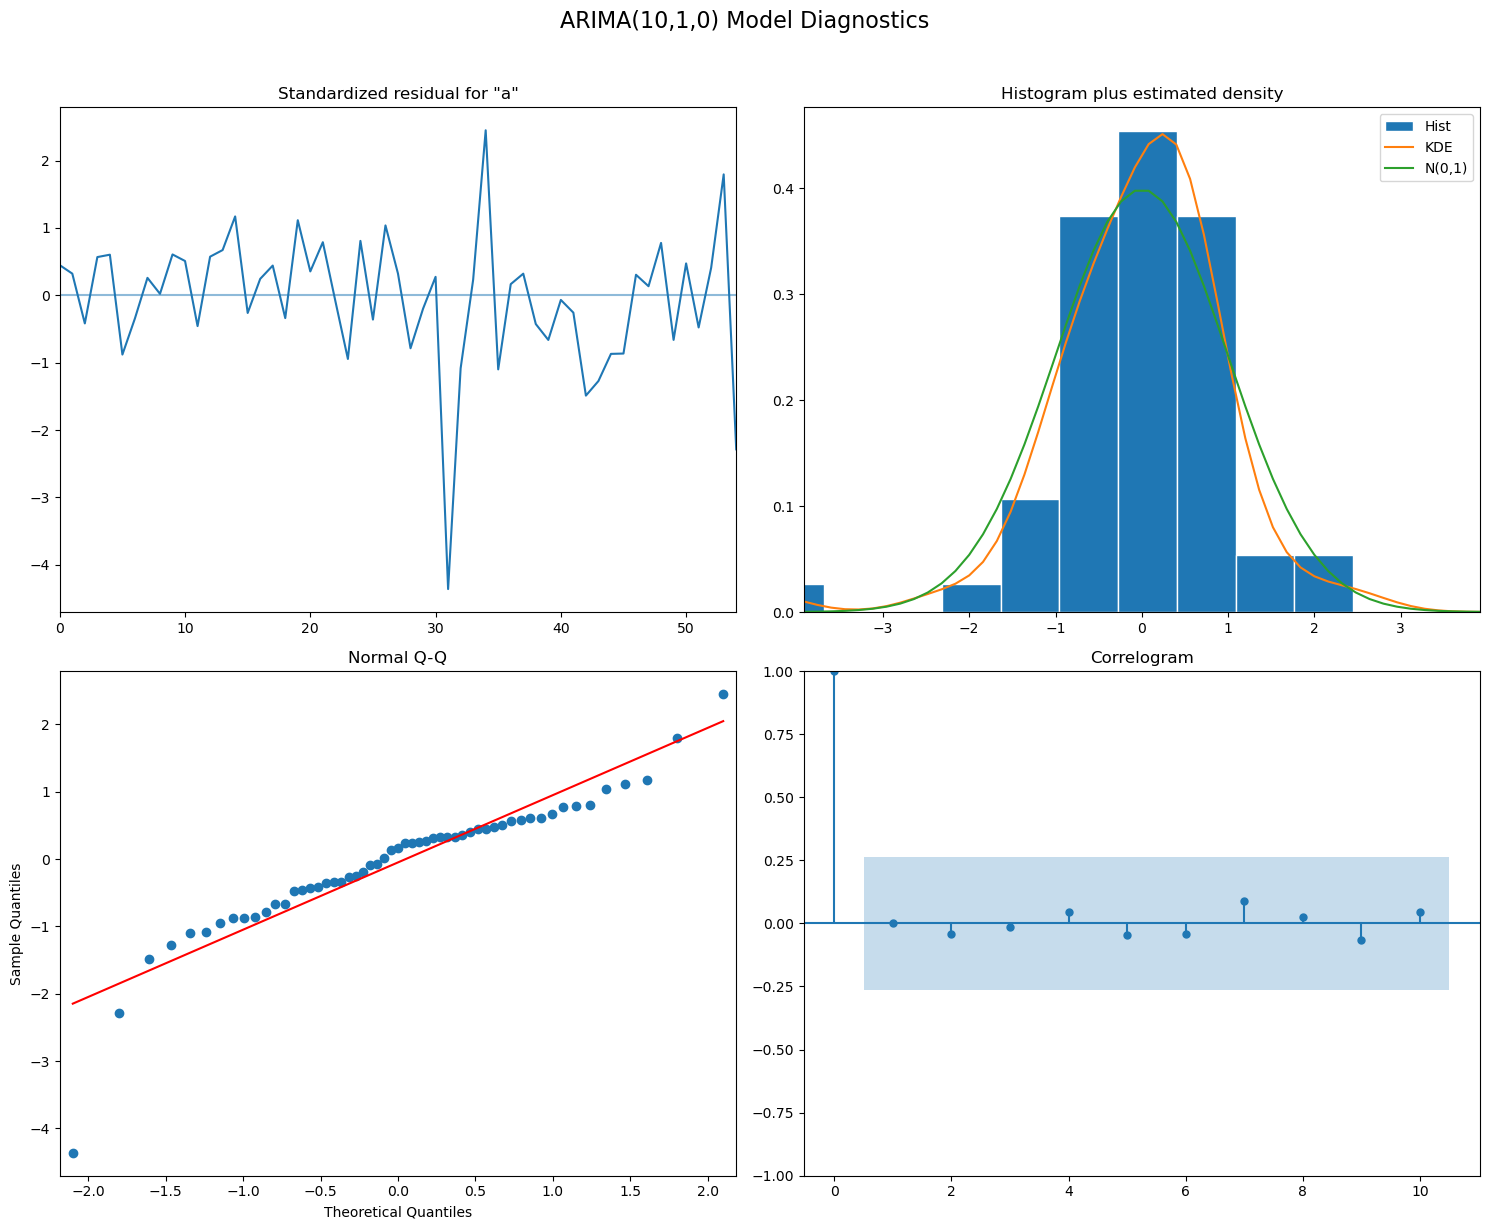

In [49]:
# Plot diagnostics
arima_fit.plot_diagnostics(figsize=(15, 12))
plt.suptitle("ARIMA(10,1,0) Model Diagnostics", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [50]:
# Forecast next 12 business days
forecast_steps = 12
arima_forecast = arima_fit.get_forecast(steps=forecast_steps)
arima_pred = arima_forecast.predicted_mean
arima_ci = arima_forecast.conf_int()


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


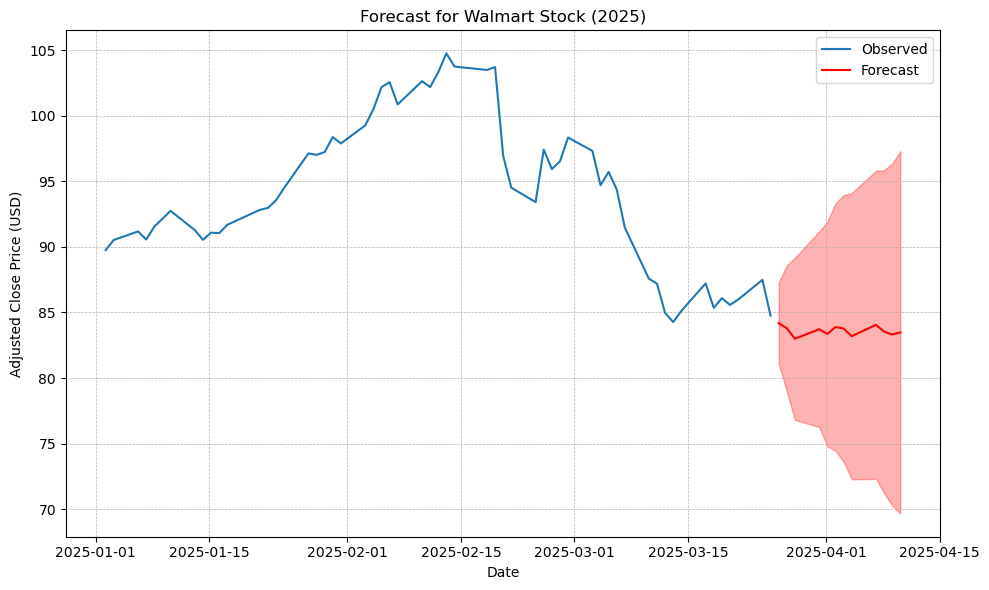

In [51]:
# Create forecast index starting from next business day
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')
arima_pred.index = forecast_index
arima_ci.index = forecast_index

# ✅ Plot forecast
plt.figure(figsize=(10, 6))
plt.plot(df['adj_close'], label='Observed')
plt.plot(arima_pred, label='Forecast', color='red')
plt.fill_between(arima_ci.index, arima_ci.iloc[:, 0], arima_ci.iloc[:, 1], color='red', alpha=0.3)
plt.title('Forecast for Walmart Stock (2025)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (USD)')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


**2. SARIMA**

**Identify Seasonality**

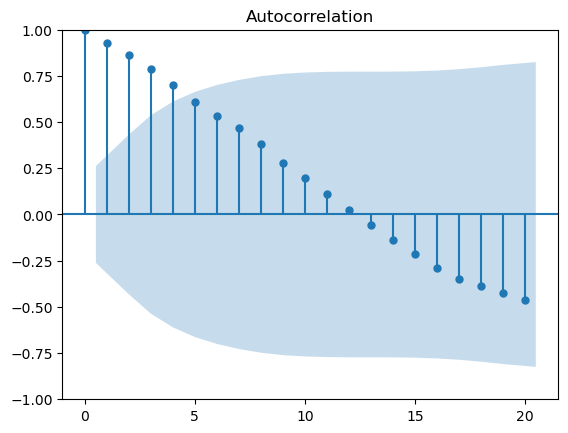

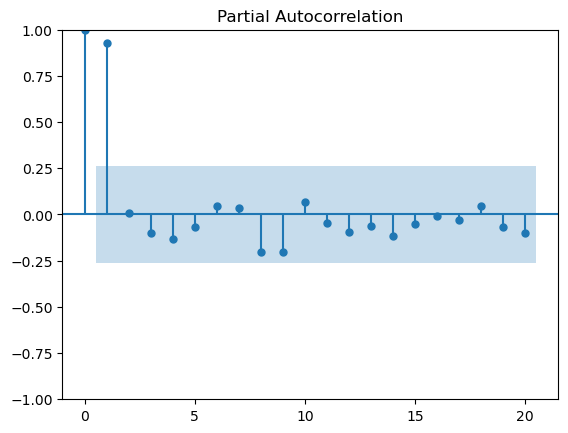

In [54]:
# Plot ACF and PACF with valid number of lags
plot_acf(df['adj_close'], lags=20)
plot_pacf(df['adj_close'], lags=20)
plt.show()

**Fit SARIMA Model**

In [55]:
# SARIMA(p,d,q)(P,D,Q,s)
sarima_model = SARIMAX(df['adj_close'], order=(1,1,1), seasonal_order=(1,1,1,5), enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit()
print(sarima_result.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70271D+00    |proj g|=  1.28870D-01

At iterate    5    f=  1.61663D+00    |proj g|=  1.66159D-02

At iterate   10    f=  1.61517D+00    |proj g|=  5.52398D-03

At iterate   15    f=  1.61500D+00    |proj g|=  4.20798D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   3.801D-06   1.615D+00
  F =   1.6149989748992581     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
        

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


**Forecast and Plot**

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


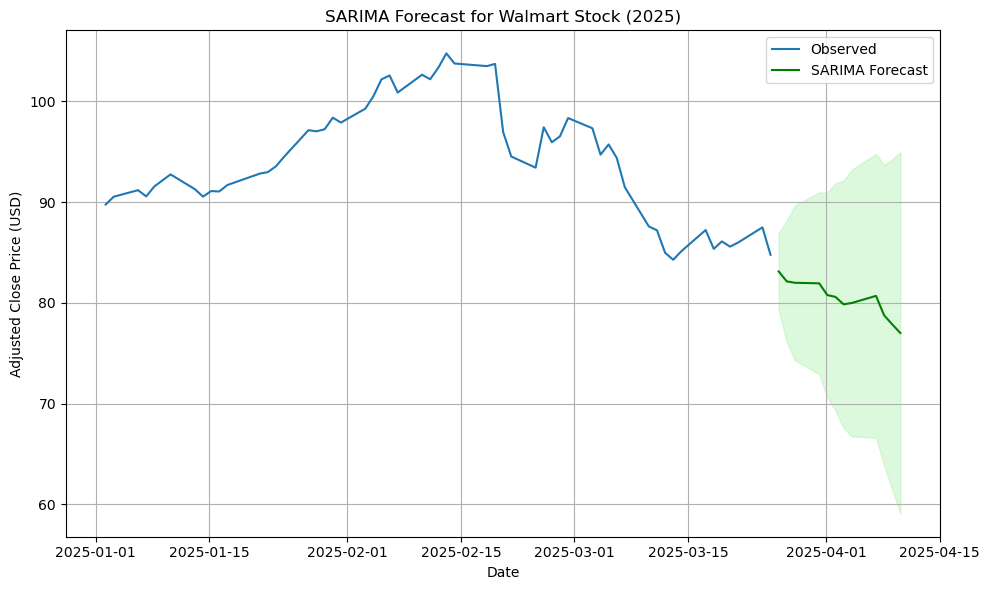

In [56]:
forecast_steps = 12
sarima_forecast = sarima_result.get_forecast(steps=forecast_steps)
sarima_pred = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int()

# Assign correct forecast index
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')
sarima_pred.index = forecast_index
sarima_ci.index = forecast_index

# Plot forecast
plt.figure(figsize=(10, 6))
plt.plot(df['adj_close'], label='Observed')
plt.plot(sarima_pred, label='SARIMA Forecast', color='green')
plt.fill_between(sarima_ci.index, sarima_ci.iloc[:, 0], sarima_ci.iloc[:, 1], color='lightgreen', alpha=0.3)
plt.title("SARIMA Forecast for Walmart Stock (2025)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price (USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**3. ARCH**

In [77]:
# Calculate daily log returns (%)
df['returns'] = 100 * np.log(df['adj_close'] / df['adj_close'].shift(1))
returns = df['returns'].dropna()

In [78]:
# Fit ARCH(1) model
model = arch_model(returns, vol='ARCH', p=1)
arch_fit = model.fit(disp='off')

# Summary of model fit
print(arch_fit.summary())


                      Constant Mean - ARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -110.148
Distribution:                  Normal   AIC:                           226.295
Method:            Maximum Likelihood   BIC:                           232.262
                                        No. Observations:                   54
Date:                Mon, Apr 14 2025   Df Residuals:                       53
Time:                        22:20:36   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.1094      0.326     -0.336      0.737 [ -0.748,  0.52

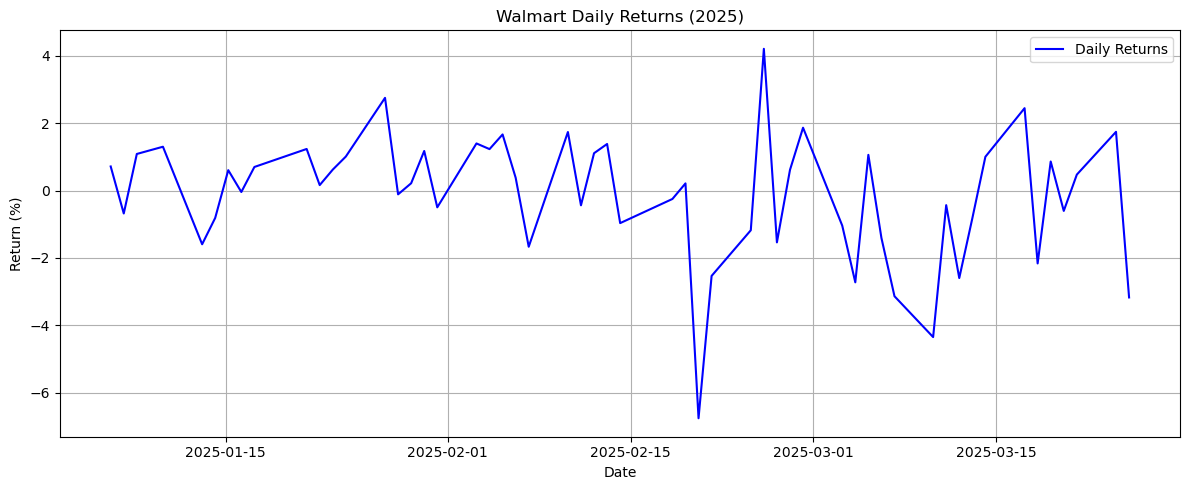

In [79]:
# Forecast volatility for next 12 days
forecast_horizon = 12
arch_forecast = arch_fit.forecast(horizon=forecast_horizon)
forecast_variance = arch_forecast.variance.values[-1, :]
forecast_volatility = np.sqrt(forecast_variance)

# Plot the returns
plt.figure(figsize=(12, 5))
plt.plot(returns, label='Daily Returns', color='blue')
plt.title('Walmart Daily Returns (2025)')
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



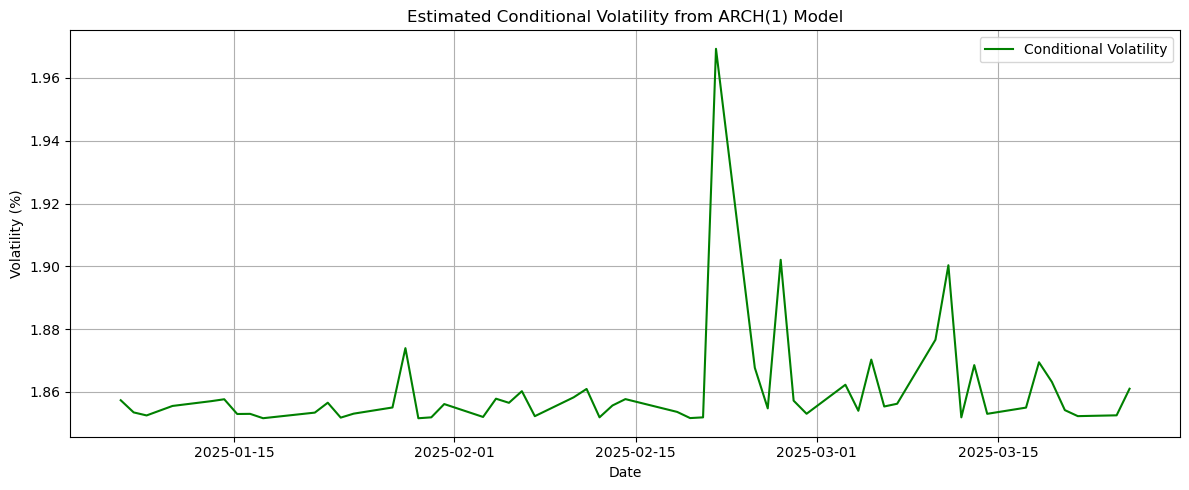

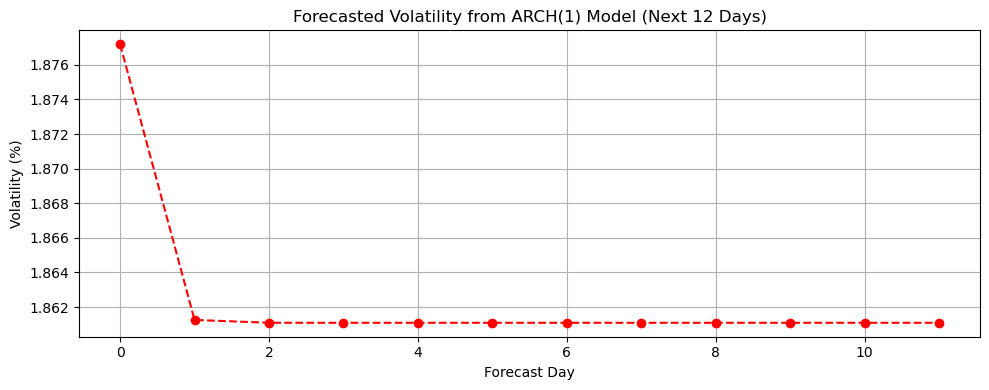

In [80]:
# Plot conditional volatility
plt.figure(figsize=(12, 5))
plt.plot(arch_fit.conditional_volatility, color='green', label='Conditional Volatility')
plt.title('Estimated Conditional Volatility from ARCH(1) Model')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot forecasted volatility
plt.figure(figsize=(10, 4))
plt.plot(forecast_volatility, marker='o', linestyle='--', color='red')
plt.title('Forecasted Volatility from ARCH(1) Model (Next 12 Days)')
plt.xlabel('Forecast Day')
plt.ylabel('Volatility (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


**4.GARCH**

In [81]:
# Compute daily log returns
df['returns'] = 100 * np.log(df['adj_close'] / df['adj_close'].shift(1))
df.dropna(inplace=True)
returns = df['returns']


**Fit GARCH(1,1) Model**

In [82]:
# Fit GARCH(1,1) model
model = arch_model(returns, vol='GARCH', p=1, q=1)
garch_fit = model.fit(disp='off')

# Print summary
print(garch_fit.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -107.796
Distribution:                  Normal   AIC:                           223.592
Method:            Maximum Likelihood   BIC:                           231.548
                                        No. Observations:                   54
Date:                Mon, Apr 14 2025   Df Residuals:                       53
Time:                        22:49:03   Df Model:                            1
                                Mean Model                               
                  coef    std err          t      P>|t|  95.0% Conf. Int.
-------------------------------------------------------------------------
mu         -6.0717e-03      0.283 -2.146e-02      0.983 [ -0.561,  

**Plot Conditional Volatility**

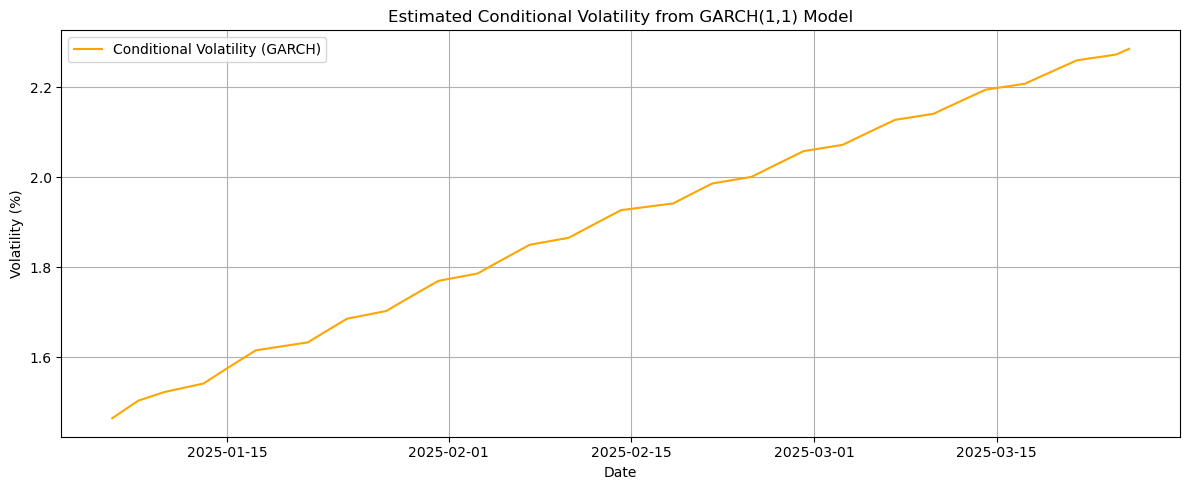

In [84]:
plt.figure(figsize=(12, 5))
plt.plot(garch_fit.conditional_volatility, color='orange', label='Conditional Volatility (GARCH)')
plt.title('Estimated Conditional Volatility from GARCH(1,1) Model')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


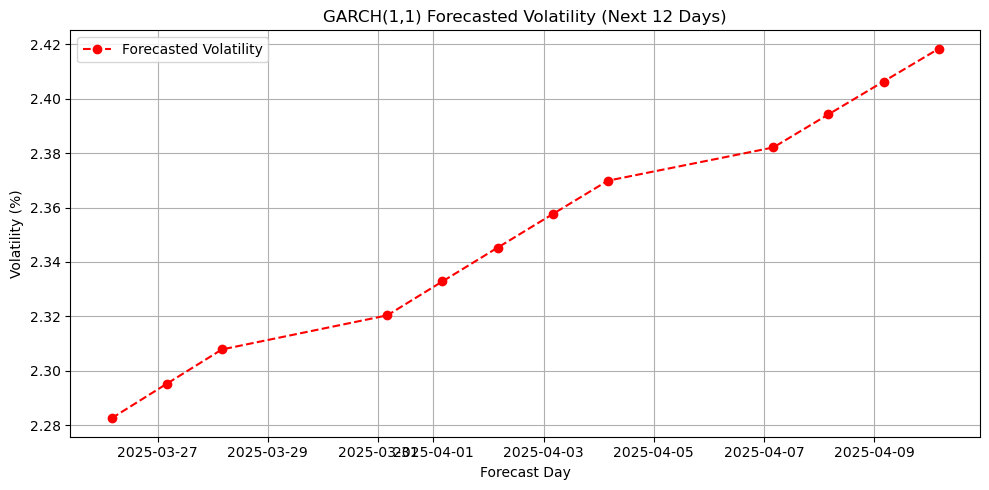

In [85]:
forecast_horizon = 12
garch_forecast = garch_fit.forecast(horizon=forecast_horizon)
forecast_var = garch_forecast.variance.values[-1, :]
forecast_vol = np.sqrt(forecast_var)

# Create future date index
last_date = returns.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='B')

# Plot forecasted volatility
plt.figure(figsize=(10, 5))
plt.plot(forecast_index, forecast_vol, marker='o', linestyle='--', color='red', label='Forecasted Volatility')
plt.title('GARCH(1,1) Forecasted Volatility (Next 12 Days)')
plt.xlabel('Forecast Day')
plt.ylabel('Volatility (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
